In [1]:
import gzip,json
import pandas as pd
import numpy as np

In [2]:
with open('AMAZON_FASHION.npy', 'rb') as f:
    a = np.load(f, allow_pickle=True)

In [3]:
df_data=pd.DataFrame(a,columns=['asin', 'overall', 'reviewText', 'reviewTime', 'reviewerID',
       'reviewerName', 'summary', 'unixReviewTime', 'verified', 'vote',
       'style', 'image'
])
df_data.head()

,asin,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,verified,vote,style,image
0,7106116521,5,Exactly what I needed.,"10 20, 2014",A1D4G1SNUZWQOT,Tracy,perfect replacements!!,1.41376e+09,1,NaN,NaN,NaN
1,7106116521,2,"I agree with the other review, the opening is ...","09 28, 2014",A3DDWDH9PX2YX2,Sonja Lau,"I agree with the other review, the opening is ...",1.41186e+09,1,3,NaN,NaN
2,7106116521,4,Love these... I am going to order another pack...,"08 25, 2014",A2MWC41EW7XL15,Kathleen,My New 'Friends' !!,1.40892e+09,0,NaN,NaN,NaN
3,7106116521,2,too tiny an opening,"08 24, 2014",A2UH2QQ275NV45,Jodi Stoner,Two Stars,1.40884e+09,1,NaN,NaN,NaN
4,7106116521,3,Okay,"07 27, 2014",A89F3LQADZBS5,Alexander D.,Three Stars,1.40642e+09,0,NaN,NaN,NaN


In [4]:
def dataHandler(df,row):
    return (str(df['reviewText'].iloc[row]),{'cats': {'neg': (3-int(df['overall'].iloc[row]))/3, 'pos': (int(df['overall'].iloc[row])-3)/3}})

from sklearn.utils import shuffle
def load_training_data(df,split):
    # Load from files
    df = shuffle(df)
    datas=[]
    for i in range(len(df)):
        datas.append(dataHandler(df_data,i))

    split = int(len(datas) * split)
    return datas[:split], datas[split:]

training_data, testing_data =load_training_data(df_data,0.8)

In [3]:
import random
import spacy
from spacy.util import minibatch, compounding

def train_model(
    training_data: list,
    test_data: list,
    iterations: int = 20
) -> None:
    # Build pipeline
    nlp = spacy.load("en") # Change this for loading medium or large models
    if "textcat" not in nlp.pipe_names:
        textcat = nlp.create_pipe(
            "textcat", config={"architecture": "simple_cnn"}
        )
        nlp.add_pipe(textcat, last=True)
    else:
        textcat = nlp.get_pipe("textcat")

    textcat.add_label("pos")
    textcat.add_label("neg")

    # Train only textcat
    training_excluded_pipes = [
        pipe for pipe in nlp.pipe_names if pipe != "textcat"
    ]
    with nlp.disable_pipes(training_excluded_pipes):
        optimizer = nlp.begin_training()
        # Training loop
        print("Beginning training")
        print("Loss\tPrecision\tRecall\tF-score")
        batch_sizes = compounding(
            4.0, 32.0, 1.001
        )  # A generator that yields infinite series of input numbers
        for i in range(iterations):
            print(f"Training iteration {i}")
            loss = {}
            random.shuffle(training_data)
            batches = minibatch(training_data, size=batch_sizes)
            for batch in batches:
                text, labels = zip(*batch)
                nlp.update(text, labels, drop=0.2, sgd=optimizer, losses=loss)
            with textcat.model.use_params(optimizer.averages):
                evaluation_results = evaluate_model(
                    tokenizer=nlp.tokenizer,
                    textcat=textcat,
                    test_data=test_data
                )
                print(
                    f"{loss['textcat']}\t{evaluation_results['precision']}"
                    f"\t{evaluation_results['recall']}"
                    f"\t{evaluation_results['f-score']}"
                )

    # Save model
    with nlp.use_params(optimizer.averages):
        nlp.to_disk("model_artifacts")

In [4]:
def evaluate_model(
    tokenizer, textcat, test_data: list
) -> dict:
    reviews, labels = zip(*test_data)
    reviews = (tokenizer(review) for review in reviews)
    true_positives = 0
    false_positives = 1e-8  # Can't be 0 because of presence in denominator
    true_negatives = 0
    false_negatives = 1e-8
    for i, review in enumerate(textcat.pipe(reviews)):
        true_label = labels[i]['cats']
        for predicted_label, score in review.cats.items():
            # Every cats dictionary includes both labels. You can get all
            # the info you need with just the pos label.
            if (
                predicted_label == "neg"
            ):
                continue
            if score >= 0.5 and true_label["pos"]:
                true_positives += 1
            elif score >= 0.5 and true_label["neg"]:
                false_positives += 1
            elif score < 0.5 and true_label["neg"]:
                true_negatives += 1
            elif score < 0.5 and true_label["pos"]:
                false_negatives += 1
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    if precision + recall == 0:
        f_score = 0
    else:
        f_score = 2 * (precision * recall) / (precision + recall)
    return {"precision": precision, "recall": recall, "f-score": f_score}

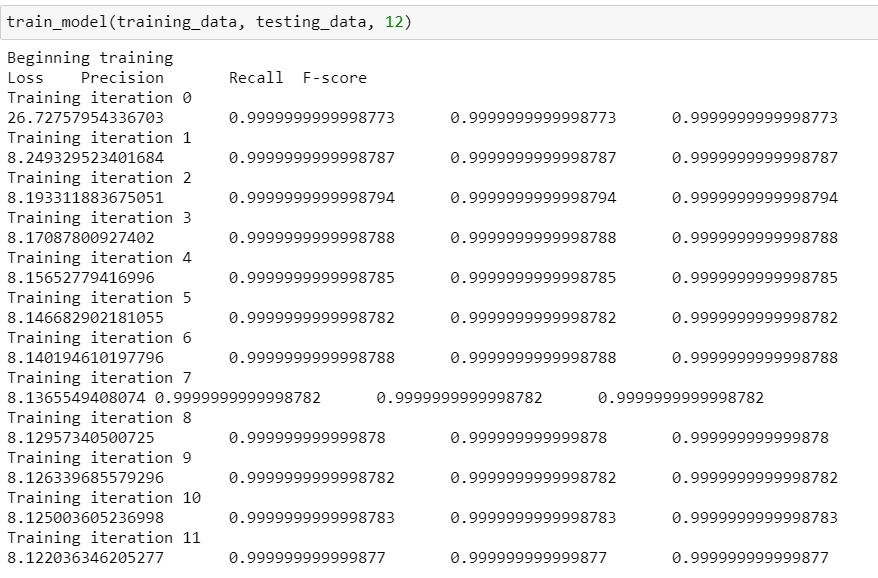

In [7]:
#train_model(training_data, testing_data, 12)#<--pls uncomment if need to do training
from IPython.display import Image 
pil_img = Image(filename='training_steps.jpeg')
display(pil_img)

In [6]:
# Load saved model
loaded_model = spacy.load("model_artifacts") 
TEST_REVIEW = '''[8:15 am, 29/10/2021] Hong Kok Wah: 教授边泡澡边上课 镜头突开惊呆学生
https://www.sinchew.com.my/?p=3383381
[10:23 am, 29/10/2021] Hong Kok Wah: https://www.enanyang.my/node/438858
[10:38 am, 29/10/2021] Kok Kheng: @Yong Keat My super  handsome Mr Socket boy.... Happy birthday ya... 🎉🎊Wish u have a great day and fast fast find a gf to 破处🤏💦🧻。😅 🤣 🤣
[11:00 am, 29/10/2021] Hong Kok Wah: Happy Birthday @Yong Keat 🎉 🎉 🎉
[11:26 am, 29/10/2021] Ze Ming: Happy birthday Ivan! 🥳🎂
[11:33 am, 29/10/2021] Yong Keat: Thanks for your wishes. No wonder I 破处in my dreams just now
[11:34 am, 29/10/2021] Yong Keat: Tq @Hong Kok Wah @Ze Ming
[11:39 am, 29/10/2021] Kok Kheng: Lolol... Meaning u just 早泄在睡梦中？
Then ur bed and ur underwear mai sticky and wet? 🤔 😅 🤣
[11:52 am, 29/10/2021] Hong Kok Wah: Yong Keat has a single lady roomate beside his room…
[11:56 am, 29/10/2021] Kok Kheng: Pretty one?
[11:56 am, 29/10/2021] Kok Kheng: Slim and pretty... Friendly and nice?
[11:57 am, 29/10/2021] Hong Kok Wah: It matched your latest preference…kind, friendly and nice
[11:57 am, 29/10/2021] Kok Kheng: How abt slim and pretty?
[11:57 am, 29/10/2021] Kok Kheng: Lol
[11:57 am, 29/10/2021] Hong Kok Wah: She borrowed us wifi for a year since MCO
[11:57 am, 29/10/2021] Kok Kheng: Show me her pic
[11:57 am, 29/10/2021] Kok Kheng: Pls
[11:57 am, 29/10/2021] Kok Kheng: Haha
[11:57 am, 29/10/2021] Kok Kheng: Or fb
[11:58 am, 29/10/2021] Kok Kheng: I go and add her if she is pretty and slim
[11:58 am, 29/10/2021] Hong Kok Wah: your latest preference is good heart with opposite slim body right
[11:58 am, 29/10/2021] Kok Kheng: 😬😎
[11:58 am, 29/10/2021] Kok Kheng: Currently no
[11:58 am, 29/10/2021] Kok Kheng: I just said if in the next few years I aso single
[11:58 am, 29/10/2021] Kok Kheng: Then will lower my preference level
[11:58 am, 29/10/2021] Kok Kheng: 🤪
[11:59 am, 29/10/2021] Kok Kheng: But then if in the next few years, I become a 钻石王老伍，then will be choosy aso... Lolololololol
[0:00 pm, 29/10/2021] Kok Kheng: With my slightly handsome look
[0:00 pm, 29/10/2021] Kok Kheng: 😜
[0:00 pm, 29/10/2021] Hong Kok Wah: Diu 你
[0:01 pm, 29/10/2021] Hong Kok Wah: Some many term and conditions you talk now
[0:01 pm, 29/10/2021] Kok Kheng: 钻石王老伍 ＝ stable income, stable job, high position, got nice car, got big house, handsome... Lol
[0:01 pm, 29/10/2021] Hong Kok Wah: We hope you 得到幸福
[0:01 pm, 29/10/2021] Hong Kok Wah: Always help to pay attention to similar preferences🤣
[0:02 pm, 29/10/2021] Kok Kheng: Preference level ~= capability
[0:02 pm, 29/10/2021] Kok Kheng: Lol
[0:04 pm, 29/10/2021] Kok Kheng: I scare I will be 砖头黄老无 instead of 钻石王老伍 in the next few years
[0:04 pm, 29/10/2021] Kok Kheng: 😅😢
[0:06 pm, 29/10/2021] Hong Kok Wah: I meet many age 30++ single lady. Look like many are prefer more on clean, and body fit guys
[0:07 pm, 29/10/2021] Hong Kok Wah: As long you make body fit you will get good one
[0:07 pm, 29/10/2021] Hong Kok Wah: You have car and house now. What you shall worry
[0:08 pm, 29/10/2021] Kok Kheng: My car is the cheapest car in the world Axia
.. Quoted from Malaysian fat female artist, wong miao miao
[0:08 pm, 29/10/2021] Kok Kheng: Lol
[0:08 pm, 29/10/2021] Kok Kheng: My condo is cheap condo
[0:08 pm, 29/10/2021] Kok Kheng: Unless u got at least honda covic, toyota corolla altis, madza 3 and above
[0:08 pm, 29/10/2021] Hong Kok Wah: I don’t even have car 🤭
[0:08 pm, 29/10/2021] Hong Kok Wah: I still use parent car till now
[0:09 pm, 29/10/2021] Kok Kheng: For condo, at least have 500k and above
[0:09 pm, 29/10/2021] Hong Kok Wah: My house unit is even smaller than many people lol
[0:09 pm, 29/10/2021] Kok Kheng: Ur toyota vios mah
[0:09 pm, 29/10/2021] Hong Kok Wah: It is 18 years old car
[0:09 pm, 29/10/2021] Kok Kheng: For penang landed, cheapest need 700k and above
[0:09 pm, 29/10/2021] Kok Kheng: I see
[0:10 pm, 29/10/2021] Kok Kheng: U got CFA mah in this year... Then next year salary 10k liao mah
[0:10 pm, 29/10/2021] Kok Kheng: 😎
[0:10 pm, 29/10/2021] Kok Kheng: Pemamg island
[0:10 pm, 29/10/2021] Hong Kok Wah: Not necessary with current economy situations
[0:11 pm, 29/10/2021] Hong Kok Wah: Many boss has realized economic structure changes with Covid and technology after 5G commence commonly
[0:12 pm, 29/10/2021] Hong Kok Wah: They are cautious in spending. Instead of hiring permanent, the hiring contract may become common in Malaysia at coming years
[0:12 pm, 29/10/2021] Kok Kheng: Nah... This is wong miao miao... Lololol
[0:13 pm, 29/10/2021] Hong Kok Wah: If the girl talk solely money you shall far away from them
[0:13 pm, 29/10/2021] Kok Kheng: Even some semicon factory too
[0:13 pm, 29/10/2021] Hong Kok Wah: Of course if you really like pretty girl with slim body and able to accept then it is fine
[0:13 pm, 29/10/2021] Kok Kheng: They said if u too poor, u cant feed them and support the whole family
[0:14 pm, 29/10/2021] Kok Kheng: Including their family
[0:14 pm, 29/10/2021] Kok Kheng: They said if u love them, u should love mai and support mai their family
[0:14 pm, 29/10/2021] Kok Kheng: Lol
[0:14 pm, 29/10/2021] Hong Kok Wah: You watch too much Youtube and drama lol
[0:15 pm, 29/10/2021] Hong Kok Wah: Have you get in touch with real woman 30’s group?
[0:15 pm, 29/10/2021] Kok Kheng: Got many normal pretty gal with good mindset in somewhere... Just u never meet them yet ya... Haha
[0:15 pm, 29/10/2021] Kok Kheng: Yeah... I kena shoot by one 30s fat ex colleague
[0:16 pm, 29/10/2021] Hong Kok Wah: Yeah. I’m bad luck lol. They are other people gf lol
[0:16 pm, 29/10/2021] Kok Kheng: Lololol
[0:16 pm, 29/10/2021] Hong Kok Wah: Sohai
[0:16 pm, 29/10/2021] Hong Kok Wah: Ask her see cermin first
[0:16 pm, 29/10/2021] Kok Kheng: Thats why there are still this kind of gals... Not like wat u said 30s women
[0:16 pm, 29/10/2021] Kok Kheng: Group
[0:17 pm, 29/10/2021] Hong Kok Wah: Mine side they are good bro
[0:17 pm, 29/10/2021] Kok Kheng: I see... Then wat are u waiting for?
[0:17 pm, 29/10/2021] Kok Kheng: Go and shoot them liao
[0:17 pm, 29/10/2021] Kok Kheng: Shoot them with love arrow
[0:17 pm, 29/10/2021] Hong Kok Wah: Some single lady even invite me to her house when she know my wifi is having issue lol
[0:18 pm, 29/10/2021] Hong Kok Wah: However the lady is too far. I don’t accept invitation lol
[0:18 pm, 29/10/2021] Hong Kok Wah: too fat
[0:18 pm, 29/10/2021] Kok Kheng: 邱比特之尖
[0:18 pm, 29/10/2021] Hong Kok Wah: Guess your market is very limited
[0:18 pm, 29/10/2021] Hong Kok Wah: You should expand market lol
[0:18 pm, 29/10/2021] Hong Kok Wah: I reserve to intro you wor
[0:19 pm, 29/10/2021] Kok Kheng: Lolol... Have u stand in front cermin like wat u said just now... Lol
[0:19 pm, 29/10/2021] Kok Kheng: When time comes, my market will be a pool of forest tree
[0:19 pm, 29/10/2021] Kok Kheng: That time I will apply random forest algo to pick the best one
[0:19 pm, 29/10/2021] Kok Kheng: Lol
[0:21 pm, 29/10/2021] Kok Kheng: My capability that time will be some sort of tools im random forest algo, Gradient boosting... Lol
[0:21 pm, 29/10/2021] Kok Kheng: Joking joking
[0:21 pm, 29/10/2021] Kok Kheng: 🤣🤣🤣
[0:21 pm, 29/10/2021] Hong Kok Wah: To be honest. The lady is really very fat
[0:21 pm, 29/10/2021] Kok Kheng: I see.. U got ur preferences.. Is ok one
[0:22 pm, 29/10/2021] Kok Kheng: Everyone got own preference
[0:22 pm, 29/10/2021] Hong Kok Wah: at least she is better than the lady you told just now
[0:22 pm, 29/10/2021] Hong Kok Wah: Bro just expand your market la, don’t talk so much
[0:23 pm, 29/10/2021] Hong Kok Wah: You meet very limited number of girls
[0:23 pm, 29/10/2021] Kok Kheng: 🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣🤣
[0:25 pm, 29/10/2021] Hong Kok Wah: Your colleague will intro girls you. I always got girls intro by different departments even I didn’t interest much
[0:25 pm, 29/10/2021] Hong Kok Wah: and also use some dating services if able to find credible and affordable price
[0:26 pm, 29/10/2021] Hong Kok Wah: Finding dating service can help easily connect to girls in other industry more swiftly compare you get number via other channels
[0:26 pm, 29/10/2021] Kok Kheng: I see i see
[0:26 pm, 29/10/2021] Hong Kok Wah: Don’t think it is wasting money. 一分钱一分货
[0:27 pm, 29/10/2021] Kok Kheng: I am now 守株待兔
[0:27 pm, 29/10/2021] Kok Kheng: Lol
[0:28 pm, 29/10/2021] Hong Kok Wah: May be you are the only virgin in the group lol
[0:28 pm, 29/10/2021] Hong Kok Wah: You will be sad if YK told you he is not virgin lol
[0:29 pm, 29/10/2021] Kok Kheng: Yeah... I got colleague intro gal to me... But at last, due to my current condition... Me 要聊不要聊 style causing her no more in frequent contact
[0:29 pm, 29/10/2021] Kok Kheng: 😱
[0:30 pm, 29/10/2021] Kok Kheng: @Yong Keat socket bro... U eat chicken rice liao oh?
[0:30 pm, 29/10/2021] Hong Kok Wah: Some pretty girl intro by my colleague is very lanci
[0:30 pm, 29/10/2021] Kok Kheng: How u be sure I am still virgin?
Lololol
[0:31 pm, 29/10/2021] Hong Kok Wah: if he get free? Lol
[0:32 pm, 29/10/2021] Kok Kheng: I feel a bit regret since she is nice at the beginning as during MCO, she cook for me... I moved to other places to rent, she help me move my stuff together
[0:32 pm, 29/10/2021] Kok Kheng: @Yong Keat u play ons?
[0:33 pm, 29/10/2021] Kok Kheng: But that time I just regard her as friend... And I dont like to chat too long time and toi frequent as I need to study and work
[0:33 pm, 29/10/2021] Hong Kok Wah: This one you talk many times. No more others?
[0:33 pm, 29/10/2021] Kok Kheng: Thats why I am some sort of 要聊不要聊style
[0:33 pm, 29/10/2021] Kok Kheng: This is the last one... Lol
[0:34 pm, 29/10/2021] Hong Kok Wah: No more other girls?
[0:34 pm, 29/10/2021] Kok Kheng: Since then, I am homebody until now
[0:34 pm, 29/10/2021] Hong Kok Wah: Diu. That’s I said you need to expand market
[0:34 pm, 29/10/2021] Kok Kheng: No need la... Since Instill got keep in touch with them
[0:35 pm, 29/10/2021] Kok Kheng: When times come, and if anyone of them is my cup of tea that time, I will woo them
[0:35 pm, 29/10/2021] Kok Kheng: I got tell u guys meh?
[0:35 pm, 29/10/2021] Kok Kheng: I seem din bring this topic out b4
[0:38 pm, 29/10/2021] Hong Kok Wah: You talk to me many times. I’m not sure about others
[0:39 pm, 29/10/2021] Kok Kheng: When times come, my statistical coincidence will be getting higher value... Meaning occurence frequency will be greater... Lol... 😜😜😜😜
[0:39 pm, 29/10/2021] Kok Kheng: Did I?
Then who is that gal and who introduce me?
[0:40 pm, 29/10/2021] Kok Kheng: Paiseh ... It is too mathematics and scientific... Hehe
[0:41 pm, 29/10/2021] Hong Kok Wah: Bro the previous CNY we meet before MCO
[0:41 pm, 29/10/2021] Hong Kok Wah: And the time we talk through call during last year MCO
[0:41 pm, 29/10/2021] Hong Kok Wah: The girl is your junior member
[0:42 pm, 29/10/2021] Hong Kok Wah: Suddenly today you said she is intro by your colleague. I got suprised
[0:42 pm, 29/10/2021] Hong Kok Wah: The lady cook to you and in the end you help her to cook and she praise you cook well
[0:42 pm, 29/10/2021] Hong Kok Wah: Am I right
[0:42 pm, 29/10/2021] Hong Kok Wah: It has been talk since the last CNY gathering 😂
[0:43 pm, 29/10/2021] Kok Kheng: No... I din help her cook... I went to her house and fried fish only
[0:43 pm, 29/10/2021] Hong Kok Wah: She praise you cook well right
[0:44 pm, 29/10/2021] Hong Kok Wah: And then you discovered she not just show care to you
[0:44 pm, 29/10/2021] Hong Kok Wah: She also show care to others and you knew she is investing on you
[0:45 pm, 29/10/2021] Hong Kok Wah: I guess you have memory shortage coz you forget tell me before 🤣
[0:47 pm, 29/10/2021] Hong Kok Wah: You fried fish at her house is consider help her cook right? That’s my memory you did help her cook in previous conversation
[0:47 pm, 29/10/2021] Kok Kheng: I see I see... Okok...
[0:47 pm, 29/10/2021] Kok Kheng: Ur memory for this situation... Lol
[0:48 pm, 29/10/2021] Hong Kok Wah: I still remember it because that day you angry
[0:48 pm, 29/10/2021] Hong Kok Wah: You said why I forget your operation
[0:48 pm, 29/10/2021] Hong Kok Wah: I said I didn’t knew at all
[0:48 pm, 29/10/2021] Kok Kheng: Then why u forget many things?
[0:48 pm, 29/10/2021] Kok Kheng: What operation?
[0:48 pm, 29/10/2021] Hong Kok Wah: Regarding to heart
[0:49 pm, 29/10/2021] Hong Kok Wah: I got to know after you told me at car
[0:49 pm, 29/10/2021] Hong Kok Wah: heart beat
[0:50 pm, 29/10/2021] Hong Kok Wah: I can remember coz you are angry on that day…I got shock when you told me regarding with your operation detail
[0:50 pm, 29/10/2021] Hong Kok Wah: I can remember coz you are angry. Otherwise my memory is bad 😂
[1:00 pm, 29/10/2021] Kok Kheng: Chiew... Okok
[1:00 pm, 29/10/2021] Kok Kheng: Next time pls rmb bros stuff

. Lol
[1:03 pm, 29/10/2021] Hong Kok Wah: Okok
[1:06 pm, 29/10/2021] Kok Kheng: @Yong Keat u still virgin ohh?
[1:07 pm, 29/10/2021] Hong Kok Wah: @Yong Keat Kok Kheng is worrying now lol
[1:08 pm, 29/10/2021] Hong Kok Wah: Don’t tell him. Let him 心思思
[1:08 pm, 29/10/2021] Kok Kheng: Dont copy my statement
[1:09 pm, 29/10/2021] Kok Kheng: 🐈
[1:10 pm, 29/10/2021] Kok Kheng: Wei... Mr socket... Pls tell me... Lol
[1:10 pm, 29/10/2021] Yong Keat: As virgin as you
[1:10 pm, 29/10/2021] Kok Kheng: 😍😍😍
[1:10 pm, 29/10/2021] Kok Kheng: 😁😁😂😂
[1:11 pm, 29/10/2021] Hong Kok Wah: I’m virgin in thinking
[1:11 pm, 29/10/2021] Hong Kok Wah: Lol
[1:11 pm, 29/10/2021] Hong Kok Wah: How to determine virgin
[1:12 pm, 29/10/2021] Kok Kheng: U mind and physical are no more virgin
[1:12 pm, 29/10/2021] Kok Kheng: Lolol
[1:12 pm, 29/10/2021] Kok Kheng: Urs whole body include ur spirit are in blue
[1:12 pm, 29/10/2021] Kok Kheng: Lolol
[1:12 pm, 29/10/2021] Hong Kok Wah: I have a virgin mind
[1:13 pm, 29/10/2021] Hong Kok Wah: I don’t like sex before marriage 🤭
[1:13 pm, 29/10/2021] Hong Kok Wah: I don’t watch porn at Android TV
[1:13 pm, 29/10/2021] Hong Kok Wah: Lol 😆
[1:15 pm, 29/10/2021] Kok Kheng: But u went to chicken roce shop bought chicken rice eat right?
[1:15 pm, 29/10/2021] Kok Kheng: U told me it is delicious
[1:15 pm, 29/10/2021] Kok Kheng: Lolol
[1:15 pm, 29/10/2021] Hong Kok Wah: My body get polluted by chicken rice…but my soul is still noble and virgin lol
[1:15 pm, 29/10/2021] Kok Kheng: 💦💦💦💦💦🤣🤣🤣🤣🤣🤣
[1:15 pm, 29/10/2021] Kok Kheng: 👏🏻👏🏻👏🏻👏🏻
[1:16 pm, 29/10/2021] Kok Kheng: 👌🏻👌🏻👌🏻👌🏻👌🏻
[1:16 pm, 29/10/2021] Kok Kheng: No worries... I understood..., 😝😝😝😝
[1:20 pm, 29/10/2021] Kok Kheng: My soul is virgin and noble and but want makan chicken rice... But my body dont take actiom to go to the chicken rice shop... 😭
[1:21 pm, 29/10/2021] Kok Kheng: Lets have a trip to pattaya
[1:21 pm, 29/10/2021] Kok Kheng: We thr eat foreign chicken ric3... Different flavours and delicious too
[1:22 pm, 29/10/2021] Hong Kok Wah: Hygiene is a question mark to eat chicken rice
[1:22 pm, 29/10/2021] Hong Kok Wah: Let @Loke Jia Li explain to you in detail everything
[1:22 pm, 29/10/2021] Kok Kheng: I long time no go ti pattaya... Guys heaven
[1:22 pm, 29/10/2021] Hong Kok Wah: Jia Li is master of chicken rice foodchain
[1:23 pm, 29/10/2021] Kok Kheng: Really meh?
[1:23 pm, 29/10/2021] Kok Kheng: Why 拖loke li 落水？🤔😱
[1:24 pm, 29/10/2021] Kok Kheng: 😅
[1:24 pm, 29/10/2021] Hong Kok Wah: Bro may god bless you with STD 😂
[1:24 pm, 29/10/2021] Hong Kok Wah: Jkjk
[1:25 pm, 29/10/2021] Kok Kheng: Lolol...
[1:26 pm, 29/10/2021] Kok Kheng: Law offensive word... Nanti u kena... Lol
[1:27 pm, 29/10/2021] Hong Kok Wah: Malaysia ban LGBT but not STD lol
[1:27 pm, 29/10/2021] Hong Kok Wah: STD is common words among medical industry
[1:27 pm, 29/10/2021] Kok Kheng: This is cursing... And this is insulting... Law can be enforced if some body mind
[1:27 pm, 29/10/2021] Kok Kheng: Haha
[1:28 pm, 29/10/2021] Hong Kok Wah: Wow
[1:28 pm, 29/10/2021] Kok Kheng: No worries... I am ok with it.. Haha
[1:28 pm, 29/10/2021] Kok Kheng: Just let u know.. Lol
[1:29 pm, 29/10/2021] Hong Kok Wah: Don’t talk lady in public
[1:29 pm, 29/10/2021] Hong Kok Wah: Later you get sue by lady lol
[1:29 pm, 29/10/2021] Kok Kheng: Hmmm, we don talk in public what... We talk here in a group
[1:29 pm, 29/10/2021] Kok Kheng: Lol
[1:30 pm, 29/10/2021] Hong Kok Wah: You said your colleague fat. It is workplace sexual harassment
[1:30 pm, 29/10/2021] Kok Kheng: Insulting or cursing can be sued by anywhere if the person feel he or she being threated woth something
[1:30 pm, 29/10/2021] Hong Kok Wah: Anyway I won’t become whistleblower relax bro
[1:30 pm, 29/10/2021] Kok Kheng: No direct insulting and I din mentioned the person name ya...
[1:31 pm, 29/10/2021] Kok Kheng: If u have lawyer friend, u can consult them
[1:31 pm, 29/10/2021] Hong Kok Wah: You use her photo to talk…against copyright
[1:32 pm, 29/10/2021] Hong Kok Wah: my sister is studying lawyer license now lol
[1:32 pm, 29/10/2021] Hong Kok Wah: Relax 🤣
[1:33 pm, 29/10/2021] Hong Kok Wah: By the way find a gf is appropriate way to avoid STD
[1:36 pm, 29/10/2021] Kok Kheng: This is general photo... Can be found anywhere in website... So no copyright issue... Lol
[1:37 pm, 29/10/2021] Kok Kheng: Direct words insulting will  make u offense towards law
[1:37 pm, 29/10/2021] Kok Kheng: U can consult ur sis
[1:37 pm, 29/10/2021] Hong Kok Wah: You quote her in conversation without her permission
[1:38 pm, 29/10/2021] Kok Kheng: But she so sad she is still studying... If i sue u, u gonna find other lawyer... Haha
[1:38 pm, 29/10/2021] Hong Kok Wah: Bro you insult my body shape and face too lol
[1:39 pm, 29/10/2021] Kok Kheng: It is none of ur business.. Becuase she din get any bad result from me
[1:39 pm, 29/10/2021] Hong Kok Wah: If you don’t have lawyer I may ask sister explain to you lol
[1:39 pm, 29/10/2021] Kok Kheng: Lol... I just mean to look at our standard and dont choosy when u try to choose... Haha
[1:40 pm, 29/10/2021] Hong Kok Wah: It is insulting
[1:40 pm, 29/10/2021] Hong Kok Wah: haha
[1:40 pm, 29/10/2021] Kok Kheng: I may have... If want I can contact my friend.. He is lawyer now...
[1:40 pm, 29/10/2021] Kok Kheng: Is that threating ur life?
[1:41 pm, 29/10/2021] Kok Kheng: STD can be life threatening
[1:41 pm, 29/10/2021] Kok Kheng: Just like u persuade ppl dont be choosy
[1:41 pm, 29/10/2021] Kok Kheng: It is some kind of advice i think
[1:41 pm, 29/10/2021] Kok Kheng: U aso got advise me right?
[1:41 pm, 29/10/2021] Hong Kok Wah: It causing my mind blow shock and cause me dislike woman anymore. It also cause me dislike to watch japanese action movie anymore
[1:41 pm, 29/10/2021] Kok Kheng: Haha
[1:41 pm, 29/10/2021] Hong Kok Wah: How painful you know
[1:41 pm, 29/10/2021] Kok Kheng: Lololol...
[1:42 pm, 29/10/2021] Kok Kheng: It doesnt link to how our look is like
[1:42 pm, 29/10/2021] Kok Kheng: It is ur freedom to watch Japanese action movies if u want
[1:42 pm, 29/10/2021] Kok Kheng: It is ur preferences... Lol
[1:43 pm, 29/10/2021] Hong Kok Wah: It is 精神上伤害
[1:43 pm, 29/10/2021] Hong Kok Wah: Can seek claim and compensation
[1:44 pm, 29/10/2021] Kok Kheng: Okok... Haha...
[1:44 pm, 29/10/2021] Hong Kok Wah: 🤣
[1:45 pm, 29/10/2021] Kok Kheng: Then u need to get psychological report from professional to prove u are losing ur mental health
[1:45 pm, 29/10/2021] Kok Kheng: Lolol
[1:46 pm, 29/10/2021] Kok Kheng: But insulting is kind of law offense and can be direct aue
[1:46 pm, 29/10/2021] Kok Kheng: Sue*
[1:47 pm, 29/10/2021] Hong Kok Wah: You also need evidence it cause you life threatening and body injury report?
[1:48 pm, 29/10/2021] Hong Kok Wah: Or else the judge may think it was just merely a joke conversation between friend
[1:48 pm, 29/10/2021] Hong Kok Wah: Which law and act apply with whatsapp conversation
[1:49 pm, 29/10/2021] Hong Kok Wah: You insult me small dick before 😂
[1:50 pm, 29/10/2021] Hong Kok Wah: and insult me I have a black face
[1:52 pm, 29/10/2021] Kok Kheng: Haha.... Okok... Do u admit it?
I din see ur dick aso... May be ur dick is bigger and whiter than me.. Who knows...
[1:52 pm, 29/10/2021] Hong Kok Wah: You never see and insult it is small dick
[1:52 pm, 29/10/2021] Kok Kheng: Yeah.. It is joke conversation... But koje conversation got ask u die.. Ask u get serious dise?
[1:53 pm, 29/10/2021] Kok Kheng: As u said it is joke conversation lol
[1:53 pm, 29/10/2021] Kok Kheng: Diseases,*
[1:53 pm, 29/10/2021] Kok Kheng: Got wish u hamkachan?
[1:54 pm, 29/10/2021] Kok Kheng: No right?
[1:54 pm, 29/10/2021] Kok Kheng: It is damn life cursing instead of joke conversation
[1:54 pm, 29/10/2021] Kok Kheng: Lol
[1:59 pm, 29/10/2021] Kok Kheng: This sentence is ok...
Instead u direct said may god bless u get STD, u can persuade like pls dont go and do this, else u may get STD...
[1:59 pm, 29/10/2021] Kok Kheng: Intention from the sentence is obvious...
[1:59 pm, 29/10/2021] Kok Kheng: 🤣🤣🤣🤣🤣🤣🤣🤣
[2:02 pm, 29/10/2021] Hong Kok Wah: Lol
[2:02 pm, 29/10/2021] Kok Kheng: Rmb... If again, will not let go anymore...
[2:03 pm, 29/10/2021] Kok Kheng: 😉
[2:05 pm, 29/10/2021] Hong Kok Wah: Next time don’t say small dick
[2:06 pm, 29/10/2021] Hong Kok Wah: It is discrimination act, and spread rumors (you never measure before) to cause people with reputation damage. It can sue
[2:07 pm, 29/10/2021] Hong Kok Wah: It is definitely can sue with law since you said I have a small dick and black face lol
[2:07 pm, 29/10/2021] Hong Kok Wah: I didn’t admit anything
[2:16 pm, 29/10/2021] Kok Kheng: I dont think so as u have said jury may think this is just joke conversation
[2:16 pm, 29/10/2021] Kok Kheng: Pls take note
[2:17 pm, 29/10/2021] Kok Kheng: U dint admit anything and that time just a joke conversation so u lose nothing unless u take it seriously
[2:17 pm, 29/10/2021] Kok Kheng: Jury aso will take this as joke conversation
[2:17 pm, 29/10/2021] Hong Kok Wah: Yes I treat it as joke but no more next time
[2:17 pm, 29/10/2021] Hong Kok Wah: We are bro I won’t sue 😎
[2:17 pm, 29/10/2021] Kok Kheng: But life threatening and insulting is different case and sentence has the intention, are u?
[2:17 pm, 29/10/2021] Hong Kok Wah: No such intention
[2:18 pm, 29/10/2021] Hong Kok Wah: It merely a joke for you don’t go prostitution
[2:18 pm, 29/10/2021] Kok Kheng: Ues we are bro, so I will sue if u have the intention as it is life threatening
[2:18 pm, 29/10/2021] Kok Kheng: Then pls use proper sentence
[2:18 pm, 29/10/2021] Kok Kheng: Or not direct wish the person blessing with STD ya
[2:20 pm, 29/10/2021] Kok Kheng: This time I just take it as joke since we are making joke of each other but rmb dont use words that cursing ppl unless u r very angry (as lost tome very long time ago I did) and I found it is not correct as ppl can sue so I din even I am angry now hope so... even though u r angry cannot curse...
[2:20 pm, 29/10/2021] Hong Kok Wah: anything can sue in law la
[2:21 pm, 29/10/2021] Kok Kheng: That's why many thing can bring onto court
[2:21 pm, 29/10/2021] Kok Kheng: Then fight and see who is the winner
[2:21 pm, 29/10/2021] Hong Kok Wah: Many things can sue actually
[2:22 pm, 29/10/2021] Kok Kheng: If u curse next time, lets bring it to court... Hope not so
[2:22 pm, 29/10/2021] Hong Kok Wah: It is depend how much $$ you have
[2:22 pm, 29/10/2021] Kok Kheng: Just reminder as bro
[2:22 pm, 29/10/2021] Hong Kok Wah: Yes I remember the curse thing
[2:22 pm, 29/10/2021] Kok Kheng: Depends on the lawyer capabilities and how they play the game
[2:23 pm, 29/10/2021] Hong Kok Wah: Please remember don’t say the words with discrimination like fat, small dick, black etc
[2:23 pm, 29/10/2021] Hong Kok Wah: It also can bring into court as for your knowledge
[2:23 pm, 29/10/2021] Kok Kheng: Unless u dont want to play joke d
[2:23 pm, 29/10/2021] Kok Kheng: Lol
[2:23 pm, 29/10/2021] Kok Kheng: These words u like to say too right?
[2:24 pm, 29/10/2021] Kok Kheng: If mot mistaken u always use this words aso
[2:24 pm, 29/10/2021] Kok Kheng: As a joke, I feel nothing
[2:24 pm, 29/10/2021] Hong Kok Wah: You threatening me with law. How I suppose to take it joke next time lol
[2:24 pm, 29/10/2021] Kok Kheng: Unless u mentioned not to say again... Then I will know u dont want to make joke anymore so I wont say again
[2:24 pm, 29/10/2021] Hong Kok Wah: You spoke out is joke. Mine spoke out is offense. What is this
[2:25 pm, 29/10/2021] Kok Kheng: I mean did I wish u get std or curse ur family?
[2:25 pm, 29/10/2021] Kok Kheng: Luckily u din curse my family and u curse me solely only...
[2:26 pm, 29/10/2021] Kok Kheng: Even though I know u go eat chicken rice... But I din curse u get STD right?
[2:27 pm, 29/10/2021] Hong Kok Wah: I didn’t comes with curse intention even though it look like it
[2:27 pm, 29/10/2021] Kok Kheng: Sentence structure play main role
[2:27 pm, 29/10/2021] Hong Kok Wah: Just like you said my dick is small and make laugh on it among others
[2:27 pm, 29/10/2021] Kok Kheng: Thats why we learn sentence structure in primary school d
[2:27 pm, 29/10/2021] Hong Kok Wah: It may cause potentially reputation. I thought it was joke
[2:27 pm, 29/10/2021] Hong Kok Wah: reputation damage. I took it cause we are bro
[2:28 pm, 29/10/2021] Hong Kok Wah: Suddenly you told me it was against law, yes please check your previous jokes that many against law too
[2:28 pm, 29/10/2021] Kok Kheng: If not mistaken, I rmb u said my dick is small 1st...so I omly make joke of it... Is ok even my dick small who knows when got my loved lady my dick will become bigger... This is all joke
[2:29 pm, 29/10/2021] Hong Kok Wah: Where I said your dick is small 🤭
[2:29 pm, 29/10/2021] Kok Kheng: Show me if I did say any cursing life words
[2:29 pm, 29/10/2021] Kok Kheng: This is one of it
[2:30 pm, 29/10/2021] Hong Kok Wah: I said you can*
[2:30 pm, 29/10/2021] Kok Kheng: After I said I have no stable income and job yet
[2:30 pm, 29/10/2021] Kok Kheng: Thats why I will take it as joke
[2:30 pm, 29/10/2021] Hong Kok Wah: Do I implied 100% you are white dick
[2:30 pm, 29/10/2021] Hong Kok Wah: 😂
[2:31 pm, 29/10/2021] Hong Kok Wah: This is what I meant
[2:31 pm, 29/10/2021] Kok Kheng: It will imply as I have a slightly white and smooth face that u admire... Lol
[2:32 pm, 29/10/2021] Kok Kheng: I din said ursol one is offense from the sentense i show just now...

I just said u make offense as u cursing ppl to get disease
[2:32 pm, 29/10/2021] Hong Kok Wah: See I have put facial expression to indicate jokes
[2:32 pm, 29/10/2021] Hong Kok Wah: But yours statement didn’t lol
[2:32 pm, 29/10/2021] Kok Kheng: Facial expression can be indicating many thinga
[2:32 pm, 29/10/2021] Hong Kok Wah: I got it, but you look so serious
[2:32 pm, 29/10/2021] Kok Kheng: Can be not joke but true laughing at the ppl u point at
[2:33 pm, 29/10/2021] Hong Kok Wah: I got it, but you look so serious
[2:33 pm, 29/10/2021] Kok Kheng: The sentense may god bless u get STD
[2:33 pm, 29/10/2021] Kok Kheng: If u dont think this is cursing
[2:33 pm, 29/10/2021] Hong Kok Wah: Ok let’s obey law and not talk something that hurt or curse other people
[2:34 pm, 29/10/2021] Hong Kok Wah: And no publicly discuss sexuality thing or joke in whatsapp as it didn’t allow at Malaysia
[2:34 pm, 29/10/2021] Kok Kheng: Then u went eat chicken rice d, next time can i directly wish u this?
[2:34 pm, 29/10/2021] Hong Kok Wah: I assume you said chicken rice
[2:34 pm, 29/10/2021] Hong Kok Wah: If you indicated prostitution I will sue lol
[2:34 pm, 29/10/2021] Kok Kheng: I mean some body curse u get STD
[2:34 pm, 29/10/2021] Kok Kheng: Simce u got eat chicken rice b4... Lol
[2:35 pm, 29/10/2021] Hong Kok Wah: Everyone eat chicken rice, you didn’t eat before?
[2:35 pm, 29/10/2021] Hong Kok Wah: I don’t have the curse intention
[2:35 pm, 29/10/2021] Kok Kheng: The sentence pls restructure next time
[2:35 pm, 29/10/2021] Hong Kok Wah: If you insist and serious I can’t comment more
[2:35 pm, 29/10/2021] Kok Kheng: Else domt use it
[2:36 pm, 29/10/2021] Hong Kok Wah: Yes I will careful with the structure
[2:36 pm, 29/10/2021] Kok Kheng: Ok... Good thanks ya... 👌 8
[2:36 pm, 29/10/2021] Kok Kheng: 😬
[2:37 pm, 29/10/2021] Kok Kheng: Anything if u feel u don't like when joking, then let me know ya... 😬
[2:38 pm, 29/10/2021] Hong Kok Wah: We need obey this law
[2:38 pm, 29/10/2021] Hong Kok Wah: Sure bro
[2:48 pm, 29/10/2021] Hong Kok Wah: @Daniel Tan yeah
[2:49 pm, 29/10/2021] Hong Kok Wah: Kok Kheng will sue if any sentences against Malaysia Law…let’s obey law now
[2:49 pm, 29/10/2021] Kok Kheng: Lol... It means in public... Meaning it will cause others or ppl they dont know us feel polluted... If we did it in kbox just amont friends i think should be ok
[2:49 pm, 29/10/2021] Kok Kheng: Haha
...
[2:50 pm, 29/10/2021] Kok Kheng: @Daniel Tan if u went to eat chicken rice b4, and that person feel not SONG abt u and wish u may god bless u gst STD
[2:50 pm, 29/10/2021] Hong Kok Wah: How to define public? We have 6 people here in a group
[2:50 pm, 29/10/2021] Kok Kheng: @Daniel Tan What would u do?
[2:50 pm, 29/10/2021] Hong Kok Wah: Public didn’t limit to garden, shopping mall, etc
[2:50 pm, 29/10/2021] Hong Kok Wah: It can mean to a group of people
[2:51 pm, 29/10/2021] Kok Kheng: Then maj GG lor... In kbox we have song that is funny and with some porny worda
[2:51 pm, 29/10/2021] Hong Kok Wah: Let’s clarify with your lawyer friend before we speak
[2:51 pm, 29/10/2021] Kok Kheng: So we cant choose this kind of song next time?
[2:51 pm, 29/10/2021] Hong Kok Wah: You can sing alone
[2:51 pm, 29/10/2021] Hong Kok Wah: If no people it cannot constitute public
[2:51 pm, 29/10/2021] Hong Kok Wah: no other people*
[2:52 pm, 29/10/2021] Kok Kheng: I am ok with it... I mean dont choose that song... As the song just wish to make the situation more funny only
[2:52 pm, 29/10/2021] Kok Kheng: For sure, if I want to start to sue.... Haha
[2:52 pm, 29/10/2021] Kok Kheng: Will consult him
[2:53 pm, 29/10/2021] Hong Kok Wah: Lol
[2:53 pm, 29/10/2021] Hong Kok Wah: Can’t imagine how busy social life if need to avoid against law
[2:53 pm, 29/10/2021] Kok Kheng: Else u feel ok if I said may god bless u fet STD since u went eat chicken rice and not just one time... Lol
[2:54 pm, 29/10/2021] Kok Kheng: Get STD*
[2:54 pm, 29/10/2021] Kok Kheng: 👌
[2:54 pm, 29/10/2021] Kok Kheng: That why I am open minded with joke... But not life cursing sentence
[2:57 pm, 29/10/2021] Hong Kok Wah: Sometimes you will change rules
[2:57 pm, 29/10/2021] Hong Kok Wah: Better to make jokes without against law
[2:59 pm, 29/10/2021] Kok Kheng: Lol.... I change rule???
[2:59 pm, 29/10/2021] Kok Kheng: Okok... 😬
[3:00 pm, 29/10/2021] Hong Kok Wah: Better to comply law. No harm lol
[3:03 pm, 29/10/2021] Kok Kheng: Lolol.... 😂😂😂😂😂😂😂'''

# Test predictions for reviews
def test_model(input_data: str = TEST_REVIEW):
    #  Load saved trained model
    loaded_model = spacy.load("model_artifacts")
    # Generate prediction
    parsed_text = loaded_model(input_data)
    # Determine prediction to return
    if parsed_text.cats["pos"] > parsed_text.cats["neg"]:
        prediction = "Positive"
        score = parsed_text.cats["pos"]
        overall =score*3+3
    else:
        prediction = "Negative"
        score = parsed_text.cats["neg"]
        overall =3-score*3
    print(f"Review text: {input_data}\nPredicted sentiment: {prediction}"
        f"\tScore: {score}")
    
    print('overall:%s'%overall)
    
test_model(TEST_REVIEW)

Review text: [8:15 am, 29/10/2021] Hong Kok Wah: 教授边泡澡边上课 镜头突开惊呆学生
https://www.sinchew.com.my/?p=3383381
[10:23 am, 29/10/2021] Hong Kok Wah: https://www.enanyang.my/node/438858
[10:38 am, 29/10/2021] Kok Kheng: @Yong Keat My super  handsome Mr Socket boy.... Happy birthday ya... 🎉🎊Wish u have a great day and fast fast find a gf to 破处🤏💦🧻。😅 🤣 🤣
[11:00 am, 29/10/2021] Hong Kok Wah: Happy Birthday @Yong Keat 🎉 🎉 🎉
[11:26 am, 29/10/2021] Ze Ming: Happy birthday Ivan! 🥳🎂
[11:33 am, 29/10/2021] Yong Keat: Thanks for your wishes. No wonder I 破处in my dreams just now
[11:34 am, 29/10/2021] Yong Keat: Tq @Hong Kok Wah @Ze Ming
[11:39 am, 29/10/2021] Kok Kheng: Lolol... Meaning u just 早泄在睡梦中？
Then ur bed and ur underwear mai sticky and wet? 🤔 😅 🤣
[11:52 am, 29/10/2021] Hong Kok Wah: Yong Keat has a single lady roomate beside his room…
[11:56 am, 29/10/2021] Kok Kheng: Pretty one?
[11:56 am, 29/10/2021] Kok Kheng: Slim and pretty... Friendly and nice?
[11:57 am, 29/10/2021] Hong Kok Wah: It matche

In [10]:
len(training_data)

706908

In [11]:
len(testing_data)

176728